# Shenna (PM & Data) - Week 1 Data Tasks

## Load calendar.csv Data

In [17]:
import pandas as pd

calendar = pd.read_csv(
    "/Users/shennalu/Downloads/calendar.csv.gz",
    compression="gzip"
)

calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2384,2025-09-22,f,NaN,NaN,3,90
1,2384,2025-09-23,f,NaN,NaN,3,90
2,2384,2025-09-24,t,NaN,NaN,3,90
3,2384,2025-09-25,f,NaN,NaN,3,90
4,2384,2025-09-26,f,NaN,NaN,3,90


In [18]:
calendar.tail()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
3161990,30843280,2026-09-19,f,NaN,NaN,20,365
3161991,30843280,2026-09-20,f,NaN,NaN,20,365
3161992,30843280,2026-09-21,f,NaN,NaN,20,365
3161993,30843280,2026-09-22,f,NaN,NaN,20,365
3161994,30843280,2026-09-23,f,NaN,NaN,20,365


In [19]:
calendar['price'].isna().mean()

np.float64(1.0)

### 1) Clean date + create “booked” indicator

In [20]:
calendar["date"] = pd.to_datetime(calendar["date"])
calendar["is_booked"] = (calendar["available"] == "f")  # True if booked/blocked, False if available

### 2) Basic booking rate per listing

In [21]:
booking_rate = (
    calendar.groupby("listing_id")["is_booked"]
    .mean()
    .reset_index()
    .rename(columns={"is_booked": "booking_rate"})
)


### 3) Weekend booking rate

In [22]:
calendar["is_weekend"] = calendar["date"].dt.weekday >= 5

weekend_booking_rate = (
    calendar[calendar["is_weekend"]]
    .groupby("listing_id")["is_booked"]
    .mean()
    .reset_index()
    .rename(columns={"is_booked": "weekend_booking_rate"})
)

### 4) Summer vs Winter booking rate

In [23]:
calendar["month"] = calendar["date"].dt.month

summer_booking_rate = (
    calendar[calendar["month"].isin([6, 7, 8])]
    .groupby("listing_id")["is_booked"]
    .mean()
    .reset_index()
    .rename(columns={"is_booked": "summer_booking_rate"})
)

winter_booking_rate = (
    calendar[calendar["month"].isin([12, 1, 2])]
    .groupby("listing_id")["is_booked"]
    .mean()
    .reset_index()
    .rename(columns={"is_booked": "winter_booking_rate"})
)


### Merge the calendar aggregates into one table

In [24]:
calendar_agg = booking_rate.merge(weekend_booking_rate, on="listing_id", how="left")
calendar_agg = calendar_agg.merge(summer_booking_rate, on="listing_id", how="left")
calendar_agg = calendar_agg.merge(winter_booking_rate, on="listing_id", how="left")

# If a listing has no weekend/summer/winter rows (rare), fill with overall booking_rate
calendar_agg["weekend_booking_rate"] = calendar_agg["weekend_booking_rate"].fillna(calendar_agg["booking_rate"])
calendar_agg["summer_booking_rate"]  = calendar_agg["summer_booking_rate"].fillna(calendar_agg["booking_rate"])
calendar_agg["winter_booking_rate"]  = calendar_agg["winter_booking_rate"].fillna(calendar_agg["booking_rate"])

calendar_agg.head()


,listing_id,booking_rate,weekend_booking_rate,summer_booking_rate,winter_booking_rate
0,2384,0.046575,0.048077,0.000000,0.000000
1,7126,0.172603,0.182692,0.086957,0.077778
2,10945,0.109589,0.115385,0.000000,0.000000
3,12140,0.572603,0.605769,1.000000,0.000000
4,28749,0.797260,0.807692,1.000000,0.766667


In [25]:
print("Rows:", calendar_agg.shape[0])
print("Duplicate listing_id:", calendar_agg["listing_id"].duplicated().sum())

calendar_agg[["booking_rate","weekend_booking_rate","summer_booking_rate","winter_booking_rate"]].describe()


Rows: 8663
Duplicate listing_id: 0


,booking_rate,weekend_booking_rate,summer_booking_rate,winter_booking_rate
count,8663.000000,8663.000000,8663.000000,8663.000000
mean,0.369990,0.378117,0.443991,0.257037
std,0.321072,0.321402,0.463097,0.374855
min,0.000000,0.000000,0.000000,0.000000
25%,0.073973,0.076923,0.000000,0.000000
50%,0.287671,0.307692,0.097826,0.011111
75%,0.613699,0.625000,1.000000,0.488889
max,1.000000,1.000000,1.000000,1.000000


## Load listings.csv Data

In [26]:
listings = pd.read_csv(
    "/Users/shennalu/Downloads/listings.csv.gz",
    compression="gzip",
    low_memory=False
)

listings.head()


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20250922033851,2025-09-22,city scrape,Hyde Park - Walk to University of Chicago,Solo Hyde Park visitors are invited to enjoy t...,The apartment is less than one block from beau...,https://a0.muscache.com/pictures/hosting/Hosti...,2613,...,4.98,4.95,4.93,R17000015609,f,1,0,1,0,1.97
1,7126,https://www.airbnb.com/rooms/7126,20250922033851,2025-09-22,city scrape,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhood.,"Ukrainian Village was just named ""Hottest Neig...",https://a0.muscache.com/pictures/51073/16c81c7...,17928,...,4.88,4.90,4.77,R24000114046,f,1,1,0,0,3.01
2,10945,https://www.airbnb.com/rooms/10945,20250922033851,2025-09-24,city scrape,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,https://a0.muscache.com/pictures/58d1a420-a24b...,33004,...,4.88,4.98,4.73,2209984,t,6,6,0,0,0.93
3,12140,https://www.airbnb.com/rooms/12140,20250922033851,2025-09-24,city scrape,Lincoln Park Guest House,Bed and Breakfast license issued by the City o...,The Guest House is in the heart of Chicago's m...,https://a0.muscache.com/pictures/miso/Hosting-...,46734,...,5.00,5.00,4.68,2398451,f,1,0,1,0,0.15
4,28749,https://www.airbnb.com/rooms/28749,20250922033851,2025-09-23,city scrape,Quirky Bucktown Loft w/ Parking No Parties,Located on a peaceful treelined street in ener...,Bucktown is a thriving community on the Northw...,https://a0.muscache.com/pictures/95884ff6-a672...,27506,...,4.88,4.93,4.73,R24000113825,f,1,1,0,0,1.47


In [27]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [28]:
listings['price'].isna().mean()

np.float64(0.0964203233256351)

### Clean Price Column

In [29]:
listings['price'] = (
    listings['price']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

In [30]:
listings['price'].describe()

count     7825.000000
mean       601.304792
std       4200.617938
min         13.000000
25%         97.000000
50%        153.000000
75%        240.000000
max      50032.000000
Name: price, dtype: float64

### Calculate Occupancy Rate

In [31]:
listings['occupancy_rate'] = 1 - (listings['availability_365'] / 365)

In [32]:
listings['occupancy_rate'].describe()

count    8660.000000
mean        0.370355
std         0.321378
min         0.000000
25%         0.073973
50%         0.287671
75%         0.613699
max         1.000000
Name: occupancy_rate, dtype: float64

### Estimate Annual Revenue

Since Inside Airbnb does not provide realized transaction revenue, we constructed an annual revenue proxy by combining listing price with observed occupancy derived from availability_365.

In [33]:
listings['estimated_annual_revenue'] = (
    listings['price'] *
    listings['occupancy_rate'] *
    365
)

In [34]:
listings[['price','occupancy_rate','estimated_annual_revenue']].head()

,price,occupancy_rate,estimated_annual_revenue
0,119.0,0.046575,2023.0
1,89.0,0.172603,5607.0
2,203.0,0.109589,8120.0
3,339.0,0.572603,70851.0
4,258.0,0.797260,75078.0


### Check Distribution

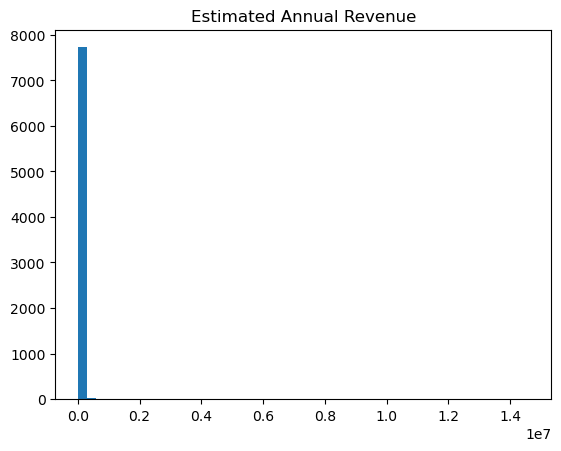

In [35]:
import matplotlib.pyplot as plt

plt.hist(listings['estimated_annual_revenue'], bins=50)
plt.title("Estimated Annual Revenue")
plt.show()

There are some huge outliers of estimated annual revenue.

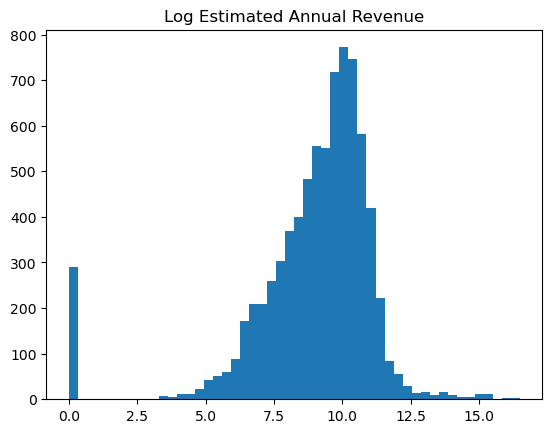

In [36]:
import numpy as np

plt.hist(np.log1p(listings['estimated_annual_revenue']), bins=50)
plt.title("Log Estimated Annual Revenue")
plt.show()

✔ Should use log_revenue as target
✔ Linear assumptions are more reasonable
✔ XGBoost will behave better
✔ SHAP values will be more stable

### Create Log Revenue

In [37]:
import numpy as np

listings['log_revenue'] = np.log1p(listings['estimated_annual_revenue'])

### Check

In [38]:
listings[['price','availability_365','estimated_annual_revenue']].describe()

,price,availability_365,estimated_annual_revenue
count,7825.000000,8660.000000,7.825000e+03
mean,601.304792,229.820554,4.688587e+04
std,4200.617938,117.302921,3.522773e+05
min,13.000000,0.000000,0.000000e+00
25%,97.000000,141.000000,3.328000e+03
50%,153.000000,260.000000,1.287500e+04
75%,240.000000,338.000000,3.112200e+04
max,50032.000000,365.000000,1.460000e+07


- Some listings have missing price
- Those rows were dropped automatically when revenue was calculated

Max price = $50,032 per night is not possible:
- Data error
- Luxury pricing anomaly
- Possibly typo

In [39]:
upper_cap = listings['estimated_annual_revenue'].quantile(0.99)

listings = listings[
    listings['estimated_annual_revenue'] <= upper_cap
]

In [40]:
listings['estimated_annual_revenue'].describe()

count      7746.000000
mean      23230.103021
std       34170.169320
min           0.000000
25%        3281.250000
50%       12584.000000
75%       30456.000000
max      426503.000000
Name: estimated_annual_revenue, dtype: float64

We winsorized the revenue distribution at the 99th percentile to reduce distortion from extreme pricing outliers.

### Remove zero-revenue listings

In [41]:
(listings['estimated_annual_revenue'] == 0).mean()

np.float64(0.03756777691711851)

Since it’s only 3.8%, remove them for modeling: 
- They are not truly “earning” listings
- They may distort clustering
- Log transformation compresses them to 0
- They don’t help predict performance drivers

In [42]:
# Remove zero revenue
listings = listings[listings['estimated_annual_revenue'] > 0]

# Cap extreme outliers at 99th percentile
upper_cap = listings['estimated_annual_revenue'].quantile(0.99)
listings = listings[listings['estimated_annual_revenue'] <= upper_cap]

# Create log target
import numpy as np
listings['log_revenue'] = np.log1p(listings['estimated_annual_revenue'])

## Final Recommendation for Target Variable

For modeling:

- Use log_revenue
- Remove zero-revenue listings
- Cap at 99th percentile

## Load Review.csv Data

In [43]:
import pandas as pd

reviews = pd.read_csv(
    "/Users/shennalu/Downloads/reviews (1).csv.gz",
    compression="gzip",
    low_memory=False
)

reviews.head()


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2384,25218143,2015-01-09,14385014,Ivan,it's a wonderful trip experience. I didn't exc...
1,2384,28475392,2015-03-24,16241178,Namhaitou,This is my first trip using Airbnb. I was a li...
2,2384,30974202,2015-04-30,26247321,Cristina,Sólo puedo decir cosas buenas de Rebecca. La h...
3,2384,31363208,2015-05-04,31293837,SuJung,Rebecca was an absolutely wonderful host.\r<br...
4,2384,31820011,2015-05-10,2873370,Krishanu,Rebecca really tried to make it feel like home...


In [44]:
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

### Convert to date format

In [45]:
reviews['date'] = pd.to_datetime(reviews['date'])

### Remove missing comments

In [46]:
reviews = reviews[reviews['comments'].notna()]

### 1) Total Review Count

In [47]:
review_count = (
    reviews
    .groupby('listing_id')
    .size()
    .reset_index(name='total_review_count')
)

### 2) Average Review Length

In [48]:
reviews['review_length'] = reviews['comments'].str.len()

avg_review_length = (
    reviews
    .groupby('listing_id')['review_length']
    .mean()
    .reset_index()
    .rename(columns={'review_length': 'avg_review_length'})
)


### 3) Reviews in Last 12 Months

In [49]:
latest_date = reviews['date'].max()
one_year_ago = latest_date - pd.DateOffset(years=1)

recent_reviews = reviews[reviews['date'] >= one_year_ago]

recent_review_count = (
    recent_reviews
    .groupby('listing_id')
    .size()
    .reset_index(name='recent_review_count')
)


### Merge Review Features Together

In [50]:
reviews_agg = review_count.merge(
    avg_review_length,
    on='listing_id',
    how='left'
)

reviews_agg = reviews_agg.merge(
    recent_review_count,
    on='listing_id',
    how='left'
)

reviews_agg.fillna(0, inplace=True)

reviews_agg.head()


,listing_id,total_review_count,avg_review_length,recent_review_count
0,2384,257,378.642023,10.0
1,7126,595,267.315966,47.0
2,10945,129,238.837209,24.0
3,12140,19,251.631579,3.0
4,28749,265,308.388679,37.0


## Build: Chicago_Airbnb_Master_v1

### Standardize Key Column

In [51]:
# listings originally had "id"
if "id" in listings.columns:
    listings = listings.rename(columns={"id": "listing_id"})

In [52]:
print(listings["listing_id"].nunique())
print(calendar_agg["listing_id"].nunique())
print(reviews_agg["listing_id"].nunique())

7380
8663
6978


### Merge All Three (listings as base, left joins)

In [53]:
master = listings.merge(calendar_agg, on="listing_id", how="left", validate="one_to_one")
master = master.merge(reviews_agg, on="listing_id", how="left", validate="one_to_one")

print("After merge:")
print("rows:", master.shape[0])
print("unique listing_id:", master["listing_id"].nunique())
print("dup listing_id:", master["listing_id"].duplicated().sum())

After merge:
rows: 7380
unique listing_id: 7380
dup listing_id: 0


### Fill Missing Values from calendar/reviews merges

In [54]:
calendar_cols = ["booking_rate", "weekend_booking_rate", "summer_booking_rate", "winter_booking_rate"]
review_cols   = ["total_review_count", "recent_review_count", "avg_review_length"]

for c in calendar_cols:
    if c in master.columns:
        master[c] = master[c].fillna(0)

for c in review_cols:
    if c in master.columns:
        master[c] = master[c].fillna(0)


### Recompute Revenue using booking_rate (calendar-based)

#### Compute target

In [55]:
master["estimated_annual_revenue"] = master["price"] * master["booking_rate"] * 365
master["log_revenue"] = np.log1p(master["estimated_annual_revenue"])

#### Clean target: drop zero + cap extreme outliers (99th pct)

In [56]:
# drop zero / invalid revenue
master = master[master["estimated_annual_revenue"] > 0]

# cap outliers
cap = master["estimated_annual_revenue"].quantile(0.99)
master = master[master["estimated_annual_revenue"] <= cap]

# recompute log after filtering
master["log_revenue"] = np.log1p(master["estimated_annual_revenue"])

print(master[["price","booking_rate","estimated_annual_revenue","log_revenue"]].describe())


             price  booking_rate  estimated_annual_revenue  log_revenue
count  7306.000000   7306.000000                7306.00000  7306.000000
mean    192.348754      0.343329               20589.98426     9.177827
std     209.686116      0.290471               21993.88540     1.478770
min      13.000000      0.002740                  28.00000     3.367296
25%      95.000000      0.079452                3838.50000     8.253097
50%     149.000000      0.279452               13116.00000     9.481664
75%     229.000000      0.567123               29915.00000    10.306149
max    6977.000000      1.000000              116350.00000    11.664367


### Select Columns for Chicago_Airbnb_Master_v1

In [57]:
keep_cols = [
    # key
    "listing_id",

    # structured (from listings)
    "price", "accommodates", "bedrooms", "bathrooms",
    "room_type", "property_type", "review_scores_rating",

    # calendar engineered
    "booking_rate", "weekend_booking_rate", "summer_booking_rate", "winter_booking_rate",

    # review engineered
    "total_review_count", "recent_review_count", "avg_review_length",

    # targets
    "estimated_annual_revenue", "log_revenue"
]

# keep only columns that exist (prevents KeyError if a column name differs)
keep_cols = [c for c in keep_cols if c in master.columns]

master_v1 = master[keep_cols].copy()

print("Master v1 shape:", master_v1.shape)
print("dup listing_id:", master_v1["listing_id"].duplicated().sum())
master_v1.head()


Master v1 shape: (7306, 17)
dup listing_id: 0


,listing_id,price,accommodates,bedrooms,bathrooms,room_type,property_type,review_scores_rating,booking_rate,weekend_booking_rate,summer_booking_rate,winter_booking_rate,total_review_count,recent_review_count,avg_review_length,estimated_annual_revenue,log_revenue
0,2384,119.0,1,1.0,1.0,Private room,Private room in condo,4.99,0.046575,0.048077,0.000000,0.000000,257.0,10.0,378.642023,2023.0,7.612831
1,7126,89.0,2,1.0,1.0,Entire home/apt,Entire rental unit,4.73,0.172603,0.182692,0.086957,0.077778,595.0,47.0,267.315966,5607.0,8.631949
2,10945,203.0,4,2.0,1.0,Entire home/apt,Entire rental unit,4.74,0.109589,0.115385,0.000000,0.000000,129.0,24.0,238.837209,8120.0,9.002209
3,12140,339.0,3,1.0,1.0,Private room,Room in boutique hotel,4.95,0.572603,0.605769,1.000000,0.000000,19.0,3.0,251.631579,70851.0,11.168348
4,28749,258.0,6,3.0,2.0,Entire home/apt,Entire loft,4.83,0.797260,0.807692,1.000000,0.766667,265.0,37.0,308.388679,75078.0,11.226296


In [58]:
master_v1[["estimated_annual_revenue", "log_revenue", "booking_rate"]].describe()

,estimated_annual_revenue,log_revenue,booking_rate
count,7306.00000,7306.000000,7306.000000
mean,20589.98426,9.177827,0.343329
std,21993.88540,1.478770,0.290471
min,28.00000,3.367296,0.002740
25%,3838.50000,8.253097,0.079452
50%,13116.00000,9.481664,0.279452
75%,29915.00000,10.306149,0.567123
max,116350.00000,11.664367,1.000000


In [59]:
master_v1.isna().mean().sort_values(ascending=False).head(10)

review_scores_rating        0.173008
bedrooms                    0.000821
bathrooms                   0.000274
listing_id                  0.000000
summer_booking_rate         0.000000
estimated_annual_revenue    0.000000
avg_review_length           0.000000
recent_review_count         0.000000
total_review_count          0.000000
winter_booking_rate         0.000000
dtype: float64

## Save Master File v1

In [60]:
import os
os.getcwd()

'/Users/shennalu/Documents/GitHub/Airbnb-Renting-Optimizer/notebooks/shenna'

## Rename Booking Rate (Suggested by Ellie)

In [61]:
master_v1 = master_v1.rename(columns={
    "booking_rate": "occupancy_proxy",
    "weekend_booking_rate": "weekend_occupancy_proxy",
    "summer_booking_rate": "summer_occupancy_proxy",
    "winter_booking_rate": "winter_occupancy_proxy"
})


In [62]:
master_v1.to_csv("Chicago_Airbnb_Master_v1.csv", index=False)

# Week 2

## Integrate clusters into Master dataset

In [63]:
import pandas as pd
import numpy as np

clusters = pd.read_csv("airbnb_cluster_labels.csv")
master   = pd.read_csv("chicago_airbnb_master_features.csv")

print("Loaded:")
print("clusters:", clusters.shape)
print("master:", master.shape)

Loaded:
clusters: (8660, 2)
master: (8660, 47)


In [64]:
clusters.head()

,id,Cluster_ID
0,2384,2
1,7126,1
2,10945,1
3,12140,2
4,28749,1


In [65]:
master.head()

,id,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,accommodates,...,property_type_clean_Entire rental unit,property_type_clean_Other,property_type_clean_Private room in home,property_type_clean_Private room in rental unit,Amenity_PCA_1,Amenity_PCA_2,Amenity_PCA_3,Amenity_PCA_4,Amenity_PCA_5,Cluster_ID
0,2384,0.0,1.0,1.0,1.0,1.0,Hyde Park,41.787900,-87.587800,1,...,False,True,False,False,1.329295,-0.556898,0.175128,0.020727,-0.516094,2
1,7126,1.0,1.0,2.0,1.0,1.0,West Town,41.901660,-87.680210,2,...,True,False,False,False,1.069204,-0.294257,-0.189411,0.683348,-0.733898,1
2,10945,1.0,9.0,87.0,1.0,1.0,Lincoln Park,41.911960,-87.639810,4,...,True,False,False,False,0.790668,0.690923,-0.934136,0.427567,0.066287,1
3,12140,0.0,1.0,1.0,1.0,0.0,Lincoln Park,41.923570,-87.649470,3,...,False,True,False,False,-0.808734,-1.063261,-0.307421,-1.043370,-2.125492,2
4,28749,1.0,1.0,7.0,1.0,1.0,Logan Square,41.920226,-87.679613,6,...,False,True,False,False,2.228907,0.735227,1.409986,0.004789,-0.312622,1


In [66]:
master_v1.head()

,listing_id,price,accommodates,bedrooms,bathrooms,room_type,property_type,review_scores_rating,occupancy_proxy,weekend_occupancy_proxy,summer_occupancy_proxy,winter_occupancy_proxy,total_review_count,recent_review_count,avg_review_length,estimated_annual_revenue,log_revenue
0,2384,119.0,1,1.0,1.0,Private room,Private room in condo,4.99,0.046575,0.048077,0.000000,0.000000,257.0,10.0,378.642023,2023.0,7.612831
1,7126,89.0,2,1.0,1.0,Entire home/apt,Entire rental unit,4.73,0.172603,0.182692,0.086957,0.077778,595.0,47.0,267.315966,5607.0,8.631949
2,10945,203.0,4,2.0,1.0,Entire home/apt,Entire rental unit,4.74,0.109589,0.115385,0.000000,0.000000,129.0,24.0,238.837209,8120.0,9.002209
3,12140,339.0,3,1.0,1.0,Private room,Room in boutique hotel,4.95,0.572603,0.605769,1.000000,0.000000,19.0,3.0,251.631579,70851.0,11.168348
4,28749,258.0,6,3.0,2.0,Entire home/apt,Entire loft,4.83,0.797260,0.807692,1.000000,0.766667,265.0,37.0,308.388679,75078.0,11.226296


In [68]:
if "id" in master.columns:
    master = master.rename(columns={"id": "listing_id"})

In [73]:
print("master_v1 columns:")
print(master_v1.columns.tolist())

print("\ncluster_master columns:")
print(cluster_master.columns.tolist())

master_v1 columns:
['listing_id', 'price', 'accommodates', 'bedrooms', 'bathrooms', 'room_type', 'property_type', 'review_scores_rating', 'occupancy_proxy', 'weekend_occupancy_proxy', 'summer_occupancy_proxy', 'winter_occupancy_proxy', 'total_review_count', 'recent_review_count', 'avg_review_length', 'estimated_annual_revenue', 'log_revenue']

cluster_master columns:
['listing_id', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'number_of_reviews_ly', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant

In [69]:
master.head()

,listing_id,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,accommodates,...,property_type_clean_Entire rental unit,property_type_clean_Other,property_type_clean_Private room in home,property_type_clean_Private room in rental unit,Amenity_PCA_1,Amenity_PCA_2,Amenity_PCA_3,Amenity_PCA_4,Amenity_PCA_5,Cluster_ID
0,2384,0.0,1.0,1.0,1.0,1.0,Hyde Park,41.787900,-87.587800,1,...,False,True,False,False,1.329295,-0.556898,0.175128,0.020727,-0.516094,2
1,7126,1.0,1.0,2.0,1.0,1.0,West Town,41.901660,-87.680210,2,...,True,False,False,False,1.069204,-0.294257,-0.189411,0.683348,-0.733898,1
2,10945,1.0,9.0,87.0,1.0,1.0,Lincoln Park,41.911960,-87.639810,4,...,True,False,False,False,0.790668,0.690923,-0.934136,0.427567,0.066287,1
3,12140,0.0,1.0,1.0,1.0,0.0,Lincoln Park,41.923570,-87.649470,3,...,False,True,False,False,-0.808734,-1.063261,-0.307421,-1.043370,-2.125492,2
4,28749,1.0,1.0,7.0,1.0,1.0,Logan Square,41.920226,-87.679613,6,...,False,True,False,False,2.228907,0.735227,1.409986,0.004789,-0.312622,1


In [75]:
master_v2 = master_v1.merge(
    master,
    on="listing_id",
    how="left",
    validate="one_to_one"
)

In [76]:
master_v2.head()

,listing_id,price_x,accommodates_x,bedrooms_x,bathrooms_x,room_type,property_type,review_scores_rating_x,occupancy_proxy,weekend_occupancy_proxy,...,property_type_clean_Entire rental unit,property_type_clean_Other,property_type_clean_Private room in home,property_type_clean_Private room in rental unit,Amenity_PCA_1,Amenity_PCA_2,Amenity_PCA_3,Amenity_PCA_4,Amenity_PCA_5,Cluster_ID
0,2384,119.0,1,1.0,1.0,Private room,Private room in condo,4.99,0.046575,0.048077,...,False,True,False,False,1.329295,-0.556898,0.175128,0.020727,-0.516094,2
1,7126,89.0,2,1.0,1.0,Entire home/apt,Entire rental unit,4.73,0.172603,0.182692,...,True,False,False,False,1.069204,-0.294257,-0.189411,0.683348,-0.733898,1
2,10945,203.0,4,2.0,1.0,Entire home/apt,Entire rental unit,4.74,0.109589,0.115385,...,True,False,False,False,0.790668,0.690923,-0.934136,0.427567,0.066287,1
3,12140,339.0,3,1.0,1.0,Private room,Room in boutique hotel,4.95,0.572603,0.605769,...,False,True,False,False,-0.808734,-1.063261,-0.307421,-1.043370,-2.125492,2
4,28749,258.0,6,3.0,2.0,Entire home/apt,Entire loft,4.83,0.797260,0.807692,...,False,True,False,False,2.228907,0.735227,1.409986,0.004789,-0.312622,1


In [78]:
print("master_v2 columns:")
print(master_v2.columns.tolist())

master_v2 columns:
['listing_id', 'price_x', 'accommodates_x', 'bedrooms_x', 'bathrooms_x', 'room_type', 'property_type', 'review_scores_rating_x', 'occupancy_proxy', 'weekend_occupancy_proxy', 'summer_occupancy_proxy', 'winter_occupancy_proxy', 'total_review_count', 'recent_review_count', 'avg_review_length', 'estimated_annual_revenue', 'log_revenue', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 'accommodates_y', 'bathrooms_y', 'bedrooms_y', 'beds', 'price_y', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'number_of_reviews_ly', 'review_scores_rating_y', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calcula

In [79]:
# Drop all _y columns
master_v2 = master_v2.loc[:, ~master_v2.columns.str.endswith('_y')]

# Rename _x columns back to original names
master_v2.columns = master_v2.columns.str.replace('_x', '', regex=False)

master_v2.head()

,listing_id,price,accommodates,bedrooms,bathrooms,room_type,property_type,review_scores_rating,occupancy_proxy,weekend_occupancy_proxy,...,property_type_clean_Entire rental unit,property_type_clean_Other,property_type_clean_Private room in home,property_type_clean_Private room in rental unit,Amenity_PCA_1,Amenity_PCA_2,Amenity_PCA_3,Amenity_PCA_4,Amenity_PCA_5,Cluster_ID
0,2384,119.0,1,1.0,1.0,Private room,Private room in condo,4.99,0.046575,0.048077,...,False,True,False,False,1.329295,-0.556898,0.175128,0.020727,-0.516094,2
1,7126,89.0,2,1.0,1.0,Entire home/apt,Entire rental unit,4.73,0.172603,0.182692,...,True,False,False,False,1.069204,-0.294257,-0.189411,0.683348,-0.733898,1
2,10945,203.0,4,2.0,1.0,Entire home/apt,Entire rental unit,4.74,0.109589,0.115385,...,True,False,False,False,0.790668,0.690923,-0.934136,0.427567,0.066287,1
3,12140,339.0,3,1.0,1.0,Private room,Room in boutique hotel,4.95,0.572603,0.605769,...,False,True,False,False,-0.808734,-1.063261,-0.307421,-1.043370,-2.125492,2
4,28749,258.0,6,3.0,2.0,Entire home/apt,Entire loft,4.83,0.797260,0.807692,...,False,True,False,False,2.228907,0.735227,1.409986,0.004789,-0.312622,1


In [81]:
print("Rows:", master_v2.shape[0])
print("Duplicate listing_id:", master_v2["listing_id"].duplicated().sum())
print("Missing cluster labels:", master_v2["Cluster_ID"].isna().sum())

Rows: 7306
Duplicate listing_id: 0
Missing cluster labels: 0


In [82]:
master_v2.to_csv("Chicago_Airbnb_Master_v2.csv", index=False)

## Quality checks

In [84]:
# No duplicates
master_v2["listing_id"].duplicated().sum()

np.int64(0)

In [85]:
# Any missing cluster labels?
master_v2["Cluster_ID"].isna().sum()


np.int64(0)

In [86]:
# Cluster sizes
master_v2["Cluster_ID"].value_counts()

Cluster_ID
1    3103
0    1787
2    1488
4     776
3     152
Name: count, dtype: int64

In [87]:
profile = master_v2.groupby("Cluster_ID").agg(
    listings=("listing_id", "count"),
    avg_price=("price", "mean"),
    avg_capacity=("accommodates", "mean"),
    avg_rating=("review_scores_rating", "mean"),
    avg_occ=("occupancy_proxy", "mean"),
    avg_revenue=("estimated_annual_revenue", "mean"),
    median_revenue=("estimated_annual_revenue", "median"),
).round(2).reset_index()

profile

,Cluster_ID,listings,avg_price,avg_capacity,avg_rating,avg_occ,avg_revenue,median_revenue
0,0,1787,183.16,3.16,4.61,0.35,22199.67,17000.0
1,1,3103,183.49,5.04,4.85,0.36,22231.42,16610.0
2,2,1488,77.08,1.95,4.70,0.38,11033.61,6882.5
3,3,152,456.41,2.36,4.72,0.05,5001.59,952.0
4,4,776,418.26,10.16,4.82,0.28,31697.51,21857.5


In [88]:
profile.to_csv("cluster_profile_table.csv", index=False)

### Validate the cluster story

Luxury outliers really highest price?

In [89]:
profile.sort_values("avg_price", ascending=False)

,Cluster_ID,listings,avg_price,avg_capacity,avg_rating,avg_occ,avg_revenue,median_revenue
3,3,152,456.41,2.36,4.72,0.05,5001.59,952.0
4,4,776,418.26,10.16,4.82,0.28,31697.51,21857.5
1,1,3103,183.49,5.04,4.85,0.36,22231.42,16610.0
0,0,1787,183.16,3.16,4.61,0.35,22199.67,17000.0
2,2,1488,77.08,1.95,4.70,0.38,11033.61,6882.5


Group retreats really highest capacity?

In [90]:
profile.sort_values("avg_capacity", ascending=False)

,Cluster_ID,listings,avg_price,avg_capacity,avg_rating,avg_occ,avg_revenue,median_revenue
4,4,776,418.26,10.16,4.82,0.28,31697.51,21857.5
1,1,3103,183.49,5.04,4.85,0.36,22231.42,16610.0
0,0,1787,183.16,3.16,4.61,0.35,22199.67,17000.0
3,3,152,456.41,2.36,4.72,0.05,5001.59,952.0
2,2,1488,77.08,1.95,4.70,0.38,11033.61,6882.5


Premium mid-range really highest rating?

In [91]:
profile.sort_values("avg_rating", ascending=False)

,Cluster_ID,listings,avg_price,avg_capacity,avg_rating,avg_occ,avg_revenue,median_revenue
1,1,3103,183.49,5.04,4.85,0.36,22231.42,16610.0
4,4,776,418.26,10.16,4.82,0.28,31697.51,21857.5
3,3,152,456.41,2.36,4.72,0.05,5001.59,952.0
2,2,1488,77.08,1.95,4.70,0.38,11033.61,6882.5
0,0,1787,183.16,3.16,4.61,0.35,22199.67,17000.0


All-checked!

## Stress-Test Segmentation Validity

In [92]:
df = master_v2.copy()

In [94]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score


In [95]:
# Candidate columns commonly used in your teammate's clustering
candidate_cols = [
    "price", "accommodates", "bedrooms", "bathrooms", "beds",
    "minimum_nights", "maximum_nights",
    "availability_365", "availability_30",
    "number_of_reviews", "reviews_per_month",
    "review_scores_rating",
    "host_is_superhost", "instant_bookable",
    "Amenity_PCA_1", "Amenity_PCA_2", "Amenity_PCA_3", "Amenity_PCA_4", "Amenity_PCA_5"
]

# Keep what exists
feature_cols = [c for c in candidate_cols if c in df.columns]
print("Using features:", feature_cols)

# Basic cleanup: convert booleans / t-f to numeric if needed
X = df[feature_cols].copy()

# Coerce to numeric safely
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")

# Fill missing values (simple baseline; consistent with many clustering pipelines)
X = X.fillna(0)

# Scale (critical)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Using features: ['price', 'accommodates', 'bedrooms', 'bathrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_365', 'availability_30', 'number_of_reviews', 'reviews_per_month', 'review_scores_rating', 'host_is_superhost', 'instant_bookable', 'Amenity_PCA_1', 'Amenity_PCA_2', 'Amenity_PCA_3', 'Amenity_PCA_4', 'Amenity_PCA_5']


In [98]:
# Ensure we have existing labels
if "Cluster_ID" not in df.columns:
    raise ValueError("Cluster_ID not found in master_v2. Add it or load the correct file.")

y_ref = df["Cluster_ID"].astype(int).values
k = len(np.unique(y_ref))

seeds = [0, 1, 2, 3, 4, 10, 21, 42, 99, 123]
results = []

for seed in seeds:
    km = KMeans(n_clusters=k, random_state=seed, n_init=20)
    y_pred = km.fit_predict(X_scaled)
    
    ari = adjusted_rand_score(y_ref, y_pred)
    sil = silhouette_score(X_scaled, y_pred)
    dbi = davies_bouldin_score(X_scaled, y_pred)
    chi = calinski_harabasz_score(X_scaled, y_pred)
    
    results.append({
        "random_state": seed,
        "ARI_vs_reference": ari,
        "silhouette": sil,
        "DBI": dbi,
        "CHI": chi
    })

stability_df = pd.DataFrame(results).sort_values("ARI_vs_reference", ascending=False)
stability_df

,random_state,ARI_vs_reference,silhouette,DBI,CHI
3,3,0.162307,0.137626,2.097942,859.782314
0,0,0.162032,0.137759,2.096977,859.778991
7,42,0.161707,0.137675,2.097224,859.789040
5,10,0.161549,0.137699,2.097404,859.783463
8,99,0.161215,0.137790,2.096026,859.788452
2,2,0.161144,0.137757,2.096667,859.788702
1,1,0.160938,0.137751,2.097136,859.788967
4,4,0.160869,0.137790,2.096404,859.784863
9,123,0.160869,0.137790,2.096404,859.784863
6,21,0.160710,0.137804,2.096721,859.787590


In [100]:
stability_df.to_csv("segmentation_stability_by_seed.csv", index=False)

In [101]:
from sklearn.utils import resample

boot_results = []
B = 20          # number of bootstrap runs (increase to 50 if you want)
frac = 0.85     # sample fraction

rng = np.random.RandomState(42)

for b in range(B):
    idx = rng.choice(df.index, size=int(frac * len(df)), replace=False)
    Xb = X_scaled[idx]
    yb_ref = y_ref[idx]
    
    km = KMeans(n_clusters=k, random_state=100 + b, n_init=20)
    yb_pred = km.fit_predict(Xb)
    
    ari = adjusted_rand_score(yb_ref, yb_pred)
    sil = silhouette_score(Xb, yb_pred)
    dbi = davies_bouldin_score(Xb, yb_pred)
    chi = calinski_harabasz_score(Xb, yb_pred)
    
    boot_results.append({
        "run": b,
        "ARI_vs_reference_subset": ari,
        "silhouette": sil,
        "DBI": dbi,
        "CHI": chi
    })

bootstrap_df = pd.DataFrame(boot_results)
bootstrap_df.describe()

,run,ARI_vs_reference_subset,silhouette,DBI,CHI
count,20.00000,20.000000,20.000000,20.000000,20.000000
mean,9.50000,0.173763,0.137849,2.087078,733.308700
std,5.91608,0.034516,0.003906,0.037756,6.909267
min,0.00000,0.140558,0.131042,1.998153,723.484796
25%,4.75000,0.157617,0.136095,2.073372,728.106261
50%,9.50000,0.162315,0.138125,2.092562,731.207688
75%,14.25000,0.166304,0.139064,2.100894,736.801209
max,19.00000,0.263629,0.146249,2.161536,747.089075


In [103]:
bootstrap_df.to_csv("segmentation_bootstrap_stability.csv", index=False)

In [104]:
k_grid = range(3, 9)
k_eval = []

for kk in k_grid:
    km = KMeans(n_clusters=kk, random_state=42, n_init=20)
    yk = km.fit_predict(X_scaled)
    k_eval.append({
        "k": kk,
        "silhouette": silhouette_score(X_scaled, yk),
        "DBI": davies_bouldin_score(X_scaled, yk),
        "CHI": calinski_harabasz_score(X_scaled, yk),
        "inertia": km.inertia_
    })

k_eval_df = pd.DataFrame(k_eval)
k_eval_df

,k,silhouette,DBI,CHI,inertia
0,3,0.154517,2.070151,1076.140095,101573.199287
1,4,0.133308,2.121825,947.849866,94649.535641
2,5,0.137675,2.097224,859.789040,89397.201850
3,6,0.141375,1.998971,816.591629,84337.417341
4,7,0.127351,2.128179,758.113337,81018.180480
5,8,0.137690,2.013399,714.855477,78015.468524


In [105]:
k_eval_df.to_csv("segmentation_k_sweep_metrics.csv", index=False)

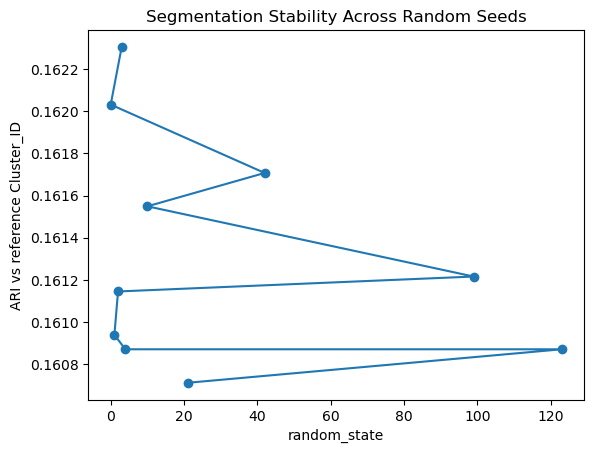

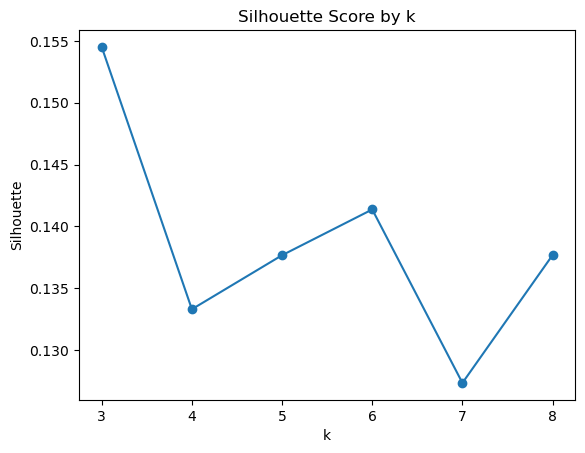

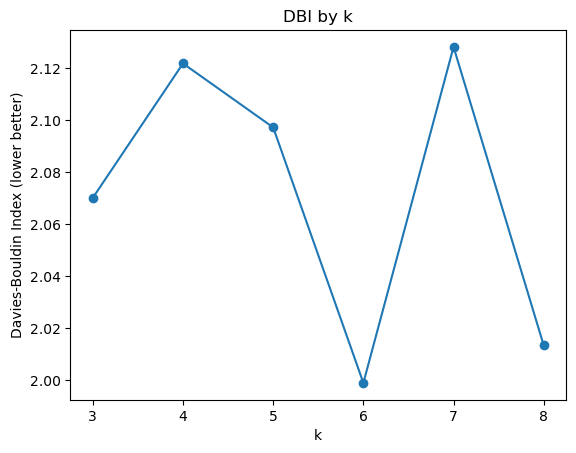

In [106]:
import matplotlib.pyplot as plt

# ARI by seed
plt.figure()
plt.plot(stability_df["random_state"], stability_df["ARI_vs_reference"], marker="o")
plt.xlabel("random_state")
plt.ylabel("ARI vs reference Cluster_ID")
plt.title("Segmentation Stability Across Random Seeds")
plt.show()

# k sweep: silhouette
plt.figure()
plt.plot(k_eval_df["k"], k_eval_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Silhouette Score by k")
plt.show()

# k sweep: DBI (lower is better)
plt.figure()
plt.plot(k_eval_df["k"], k_eval_df["DBI"], marker="o")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin Index (lower better)")
plt.title("DBI by k")
plt.show()

Segmentation is :
- Business-interpretable
- Structurally differentiated in revenue patterns
- But not statistically extremely strong

Modeling Implication

Because stability is weak:
- Do NOT build fully separate models per cluster yet.
- Use Cluster_ID as feature in global model
- Let supervised learning decide importance

Segmentation is useful descriptively, but may not be reliable enough to anchor separate predictive models.